# 3) ML Project - Air Pollution - Exploratory ML Models (Auto-ML)

<font color='blue'> Scripts by Kevin Jeswani, Junaid Zafar, & Laiba Shah 
<br>
WeCloudData Bootcamp 2022 (Part-time Cohort)<br> </font>

First we take a look at a dataset for air pollutions deaths due over time for different countries. We visualize data and develop the linear regression models on the regional and national level. The linear regression models are valuable at predicting the general trend in deaths due over time and be used to predict future deaths, where past data appears to be highly linear. It has severe limitations for many countries. Polynomial models could be explored. To explore the interaction with other features, we proceed to merge different datasets between death due to environmental factors and socio-demographic/economic factors. We then examine them in 3 tree-based machine learning models.

The set of scripts in the folder 'AirPollution_Scripts' are segmented for the purpose of clarity & convenience <br>
The following is the suggested order for running the scripts:
- 'MLProject_AirPollution_Viz_LR.ipynb' - loading the initial Kaggle air pollution deaths dataset, processing, visualizing the base dataset, linear regression examination and future predictions.
- 'MLProject_DataProcessing_OECD_WB_GBD.ipynb'  - loading raw data from world bank and GBD/OECD datasets, cleaning, and merging usable data. We test the use of fuzzy data set merging.
- 'MLProject_Exploratory_ML_Models.ipynb' **This Script**- loading the cleaning & merged dataset, model selection with PyCaret, and discussion of models/insights in modelling data.
- 'MLProject_ML_Models_refined.ipynb' - development of selected machine learning models (Extra Trees, Random Forest, XGBoost), cross-validation, & Ensemble methods; discussion of model results

The aim is to explore the intial dataset (https://www.kaggle.com/datasets/akshat0giri/death-due-to-air-pollution-19902017?resource=download), supplement it, infer trends, and make predictions on future deaths due to environmental factors. 
The data is then supplement with:
- Global Burden of Disease Study 2019 Results via OECD.stats: https://stats.oecd.org/index.aspx?lang=en# (where the Kaggle dataset seems to have extracted and cleaned data from)
- World Bank Development Indicators: https://databank.worldbank.org/source/world-development-indicators#
<br>

## 1.0 Pre-processing

Steps to run PyCaret in Conda virtual environment: <br>
- Open CMD.exe prompt in conda navigator <br>
- create a conda environment: conda create --name pycaret3 python=3.9.16 <br>
- activate conda environment: conda activate pycaret3 <br>
- install pycaret: pip install pycaret <br>
- conda install ipykernel
- create notebook kernel: python -m ipykernel install --user --name pycaret3 --display-name "display-name" <br>
<br>
Install Fugue for parallel processing backend into Spark: <br>
!pip install fugue <br>
Install pyspark <br>
!pip install pyspark
Install Dask <br>

!pip install fugue

!pip install pyspark

### 1.1 Standard Imports & Setup

In [1]:
#Data Processing
import numpy as np 
import numexpr

import pandas as pd
import csv

#Plotting
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#Machine Learning - general tools
from sklearn.model_selection import train_test_split #Test/Train and Holdout split
from sklearn.preprocessing import OrdinalEncoder #PyCaret ordinal encoder causing issues 

In [2]:
# PyCaret
from pycaret.regression import * #all regression submodules
from pycaret.parallel import FugueBackend #for parallel processing

In [3]:
# Dask - parallel processing with pycaret
# PyCaret fugue-dask does not always work
# from dask import *

In [4]:
# create pyspark session for parallel processing
# PyCaret fugue-spark does not always work
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.getOrCreate()

## 2.0 Data Examination & Processing

**NOTE** Steps in 2.0 are repeated in the 4th script for completeness

In [5]:
root = r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Project\Scripts'
root_raw=r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Project\Scripts\Raw Data'
root_proc=r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Project\Scripts\Processed'

### 2.1 Load Data into DF & Examine Contents

In [6]:
fid = '\MergedData_EnvDeaths_GDP_Pop_Income_SoDI_2.csv'
dtypes = {'Population':'float','GDP_pCapita':'float'} #specify data types as required
df_in = pd.read_csv(root_proc+fid,dtype=dtypes)
df_in

,Unnamed: 0,COU,Country,Year,Deaths_OZone,Deaths_PM2.5,Deaths_Indoor,Deaths_Handwashing,Deaths_Sanitation,Deaths_Water,Deaths_HighTemp,Deaths_LowTemp,GDP_pCapita,Population,Income_Class,SoDI
0,12,AFG,Afghanistan,2002,0.008418,0.069128,0.864084,0.154955,0.146771,0.195852,0.027761,7775.0,179.426579,22600774.0,L,0.194
1,13,AFG,Afghanistan,2003,0.007989,0.065408,0.801610,0.151253,0.144548,0.193319,0.025447,8358.0,190.683814,23680871.0,L,0.202
2,14,AFG,Afghanistan,2004,0.007311,0.060990,0.728383,0.138042,0.131303,0.176003,0.023667,7936.0,211.382074,24726689.0,L,0.209
3,15,AFG,Afghanistan,2005,0.006731,0.056720,0.657609,0.122056,0.114443,0.153736,0.020634,8244.0,242.031313,25654274.0,L,0.216
4,16,AFG,Afghanistan,2006,0.006097,0.054472,0.597933,0.107069,0.096464,0.129969,0.022527,7277.0,263.733602,26433058.0,L,0.224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5707,6055,ZWE,Zimbabwe,2015,0.002620,0.145930,0.546781,0.226782,0.150856,0.227201,0.020383,742.0,1445.069702,13814642.0,L,0.452
5708,6056,ZWE,Zimbabwe,2016,0.002946,0.138328,0.526542,0.218186,0.142138,0.215595,0.023571,762.0,1464.588957,14030338.0,L,0.459
5709,6057,ZWE,Zimbabwe,2017,0.003454,0.129761,0.506067,0.209739,0.135385,0.206877,0.008881,891.0,1235.189032,14236599.0,L,0.465
5710,6058,ZWE,Zimbabwe,2018,0.003310,0.124713,0.485084,0.199204,0.125096,0.192489,0.013527,767.0,1254.642265,14438812.0,LM,0.471


In [7]:
df_in=df_in.drop(['Unnamed: 0'],axis=1)

## 3.0 Use PyCaret for Model Selection - Regression (Boosted Trees)

**NOTE** EXERCISE CAUTION WHEN RUNNING, THE KERNEL MAY KEEP DYING, MODELS MAY NEED TO BE RUN ONE AT A TIME AND REPEATEDLY

Feature Engineering & Encoding
Ordinal Features: Income_class
- Set ord_features=['Income_Class'] for ordinal_features in setup, if auto-encoding in PyCaret desired
- To avoid dashboard issues, perform ordinal encoding with sklearn beforehand
Feature Scaling:
- By default PyCaret will use the StandardScaler, if nothing is specified in the setup()
- This will take care of the difference in magnitude between the numeric features (i.e., population being much larger than the rest) <br>

Regression with PyCaret Examples: 
- https://nbviewer.org/github/pycaret/pycaret/blob/master/tutorials/Tutorial%20-%20Regression.ipynb
- https://pycaret.readthedocs.io/en/latest/api/regression.html#

In [8]:
# Encore Ordinal Features before PyCaret to avoid dashboard mismatch issues
ordinal_encoder = OrdinalEncoder(categories=[['L', 'LM', 'UM', 'H']]) #Initialize encored on Income class col
df_in['Income_Class_encoded'] = ordinal_encoder.fit_transform(df_in[['Income_Class']])

In [9]:
# Independent Variables
# Numeric features
num_features=['GDP_pCapita','Population','SoDI','Income_Class_encoded']
date_features=['Year'] #cast as datetime
X=df_in.loc[:,num_features+date_features]
X['Year'] = X['Year'].astype('datetime64[ns]') #cast the year as datetime64

### 3.1 Model Selection for Deaths due to Indoor Air Pollution

In [10]:
#Dependent variable - classify the level of indoor pollution death
y=df_in.loc[:,['Deaths_Indoor']]

PyCaret conducts a 70-30 train-test split by default. The data saved for testing is not utilized during the cross-validation exercise. Thus, by default it saves the test set as a hold-out testing, which can be checked upon predicting target values on the full data set.

In [11]:
dataset = pd.concat([X,y],axis=1)

#### 3.1.1 Baseline Model

Setup Parameters:
- n_jobs=1 if parallel processing with fugue-spark/-dask;  required for spark/dark to avoid deadlocks; else =-1
- 10-fold Cross Validation
- session_id is equivalent to random seed to reproducibility
- Specifying 80-20 train-test split
- If using PyCaret ordinal features: ordinal_features={'Income_Class':['L','LM','UM','H']} = mismatch in dashboard output

In [12]:
# Initialize the PyCaret setup
s = setup(data=dataset,target='Deaths_Indoor',
          numeric_features=num_features,date_features=date_features,train_size=0.8,
          use_gpu=True,fold=10,n_jobs=-1,session_id=123) 

,Description,Value
0,Session id,123
1,Target,Deaths_Indoor
2,Target type,Regression
3,Original data shape,"(5712, 6)"
4,Transformed data shape,"(5712, 8)"
5,Transformed train set shape,"(4569, 8)"
6,Transformed test set shape,"(1143, 8)"
7,Numeric features,4
8,Date features,1
9,Preprocess,True


K-Fold (with k=10) is also conducted: resampling is implemented k times without data replacement, to avoid overfitting. <br>
The train set is split into sub train-test splits for the cross-validation. The test set will be saved for additional holdout testing after the model is developed.

In [13]:
#Multi-model training/test - Compare Mean Absolute Error
best_indoor = compare_models(sort='MAE',budget_time=30,fold=10,exclude='lightgbm') #30 mins budget time
# remove Light gradient boosting - causes error

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1.0062,47.0806,5.9146,0.9815,0.1739,3.7086,2.8530
dt,Decision Tree Regressor,1.0125,75.1113,7.0782,0.9738,0.1941,2.5189,2.3720
gbr,Gradient Boosting Regressor,1.9705,74.4780,7.5328,0.9641,0.4151,173.6468,2.5220
et,Extra Trees Regressor,2.1216,182.9834,12.3444,0.9263,0.4611,26.7672,2.5570
knn,K Neighbors Regressor,2.4124,104.2100,9.5871,0.9386,0.4968,61.9074,2.9640
ada,AdaBoost Regressor,6.6035,198.9587,13.6576,0.8306,1.3401,2183.5365,2.4630
huber,Huber Regressor,7.9945,3325.3974,51.5802,-0.0318,1.2900,248.8952,3.2020
dummy,Dummy Regressor,12.8199,3264.8115,51.1178,-0.0181,1.8368,5762.4278,3.1660
omp,Orthogonal Matching Pursuit,12.9492,3260.7586,51.0847,-0.0169,1.8443,4692.6749,2.8980
ridge,Ridge Regression,13.1214,3241.8840,50.9577,-0.0150,1.7899,2787.8545,2.8250


Processing:   0%|          | 0/49 [00:00<?, ?it/s]

- parallel processing with fugue-spark; set n_jobs = 1 in setup()
- set parallel = FugueBackend("dask") or = FugueBackend; does not always work

In [14]:
best_indoor

RandomForestRegressor(n_jobs=-1, random_state=123)

#### 3.1.2 Evaluate Baseline

In [22]:
# View evaluation dashboard - show inline
dashboard(best_indoor,display_format='inline')

Changing class type to RandomForestRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating importances...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard inline (terminate it with ExplainerDashboard.terminate(8050))
Dash is running on http://127.0.0.1:8050/

It appears that Random forest/Decision Tree regressors are the best options. <br>
Upon checking the SHAP results in the dashboard, the population and GDP per capita have the highest feature importance for the model.

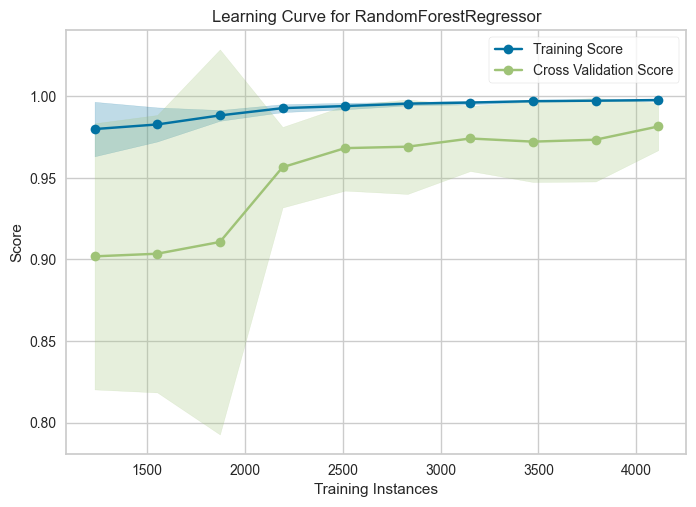

In [23]:
#Plot learning Curve
plot_model(best_indoor, plot = 'learning')

As shown in the learning curve, model training score doesn't increase greatly with with an increase in training instances between. In contrast, cross-validation model scores increase moderately from around 85% to 97%  (roughly 19% to 63% of the total test-train dataset). The model does not appear to be overfit.

In [88]:
print('Mean Deaths= %.3f | Max Deaths= %.3f'%(round(np.mean(df_in['Deaths_Indoor']),2),round(np.max(df_in['Deaths_Indoor']),2)))

Mean Deaths= 7.850 | Max Deaths= 1385.600


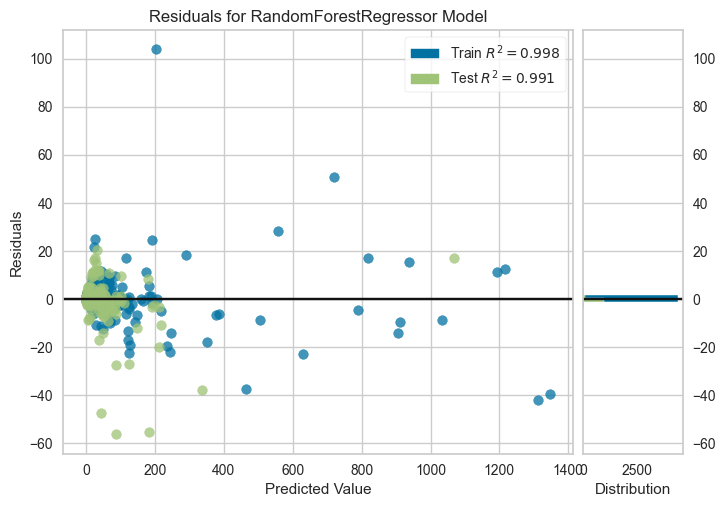

In [24]:
# Plot Residuals
plot_model(best_indoor, plot = 'residuals')

The residuals plot shows the distribution of residual (delta between actual vs predicted indoor air pollution deaths), which are larely within +/-10 deaths per 100,000, which relatively poor on the individual country level considering the {mean,max} of the metric. However, the R2 is actually around 99%

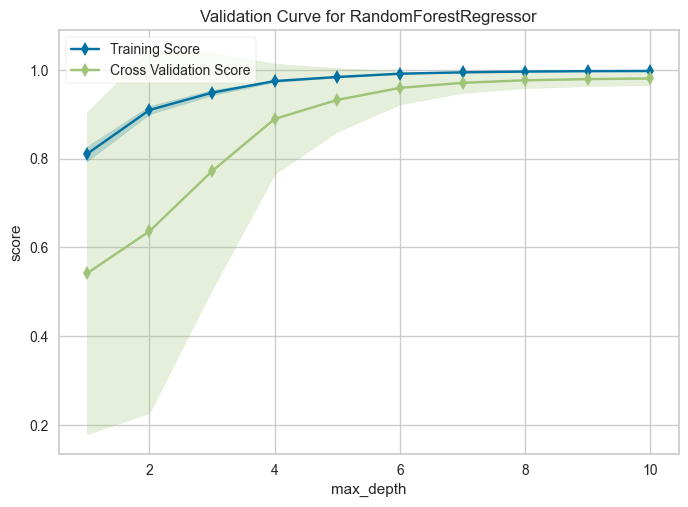

In [25]:
# Validation curve for tree depth
plot_model(best_indoor, plot = 'vc')

The actual estimator (max depth) reprents the maximum number of decision tree levels were used in the cross-validation exercise. The cross-validation score has a significant increase from around 55% to 95% from a tree depth of 2 to 7. Typically a max depth around 5 to 7 is recommended in online resources.

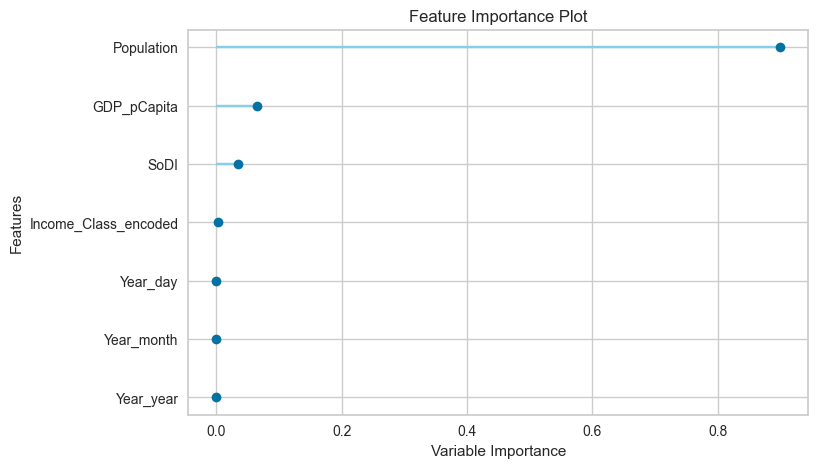

In [26]:
# Plot Feature Importance - Variable Importance (different from average importance shown in dashbaoard)
plot_model(best_indoor, plot = 'feature')

The Feature Importance plot shows that the Population drives the model at a variable importance of around 0.95, with GDP per capita coming in a distance second at around 0.1. The year does not seem to contribute much, which could be a problem when projecting the model forward into time.

#### 3.1.3 Tune Baseline

In [27]:
# Create the Random Forest Regressor Model
rf_indoor = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.1214,26.7613,5.1731,0.9890,0.2590,2.1161
1,1.1793,43.6549,6.6072,0.9944,0.1342,3.1850
2,0.4054,4.8780,2.2086,0.9780,0.1180,5.5689
3,0.6219,10.1628,3.1879,0.9592,0.2333,0.8061
4,1.2171,34.7624,5.8960,0.9857,0.1761,1.7779
5,1.5510,217.3038,14.7412,0.9497,0.1773,1.8205
6,1.2693,35.3477,5.9454,0.9849,0.1364,1.5787
7,0.6133,7.7193,2.7784,0.9872,0.1402,1.9843
8,0.7966,15.9025,3.9878,0.9959,0.1714,3.6194


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [28]:
# Check the default random forest parameters
rf_indoor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

Comments on default parameters:
- Note that max_depth is set to None, which means that the tree could be overfitting on the training data. <br>
Commonly searched hyperparameters are:
- n_estimators = number of trees in the forest
- max_depth = tree depth
- max_features = number of features considered when looking for best at every split; if None or 1.0 then max_features = n_features = bagged tree. Lower values = more randomnes. Can increase to sqrt(n total features)
- min_samples_split = min sampled data points required to split a node (decision node); lower numbers tend to overfit
- min_samples_leaf = min sampled data points required at each leaf (terminal) node; lower numbers tend to overfit
- We will leave bootstrapping enabled, to permite for a more accurate estimation

In [29]:
# Define custom hyperparamter grid only on select parameters
rf_grid = {'max_depth':[3,5,7], 
           'n_estimators':[25,50,100],
           'max_features':[0.5,1,'sqrt']}

In [30]:
# Optimize the model - optimize for MAE, pass custom hyperparameter grid; 
# force resulting model not to be overriden by baseline if performance is worse
tuned_rf_indoor = tune_model(rf_indoor,optimize='MAE',custom_grid=rf_grid,search_algorithm='grid',choose_better=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.4282,54.3249,7.3705,0.9776,0.6369,63.9489
1,3.7119,332.0570,18.2224,0.9571,0.6193,79.3246
2,1.8073,25.6951,5.0690,0.8844,0.6282,75.2500
3,2.1386,36.1435,6.0119,0.8547,0.6054,44.9476
4,3.0918,147.6153,12.1497,0.9395,0.5440,55.5251
5,2.9600,141.3657,11.8897,0.9673,0.6700,65.7365
6,2.7337,64.9904,8.0617,0.9722,0.5586,61.3956
7,2.5667,63.0243,7.9388,0.8955,0.6542,86.3050
8,2.4097,58.7306,7.6636,0.9849,0.6169,103.1619


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 27 candidates, totalling 270 fits


In [31]:
tuned_rf_indoor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': 0.5,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

The base random forest model with default parameters appears to still have less MAE than any of the models in the hyperparamter search space. Regardless of this, we will at least constrain the max_depth=7 to avoid overfitting.

#### 3.1.4 Predict

In [32]:
#Use random forest model to predict holdout testing dataset indoor pollution deaths per 100,000
predictions = predict_model(tuned_rf_indoor)
predictions

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.7853,71.9083,8.4799,0.9548,0.6542,80.7505


,GDP_pCapita,Population,SoDI,Income_Class_encoded,Year,Deaths_Indoor,prediction_label
1025,5386.467773,14587367.0,0.630,2.0,1970-01-01 00:00:00.000001996,0.064852,0.425407
935,21227.347656,29610218.0,0.809,3.0,1970-01-01 00:00:00.000001996,0.001061,0.036093
3024,117254.742188,607950.0,0.894,3.0,1970-01-01 00:00:00.000002018,0.000000,0.151802
3584,10171.480469,10289.0,0.573,3.0,1970-01-01 00:00:00.000002014,94.461243,82.835495
2131,477.762451,7081119.0,0.190,0.0,1970-01-01 00:00:00.000001994,3.347876,2.131716
...,...,...,...,...,...,...,...
524,2993.033691,230248.0,0.494,1.0,1970-01-01 00:00:00.000001998,8.676930,25.638869
5227,590.393494,4413477.0,0.556,0.0,1970-01-01 00:00:00.000001998,0.017455,1.261738
2883,7948.685547,5537620.0,0.660,2.0,1970-01-01 00:00:00.000002012,0.007826,0.309097
3941,1664.245728,3494496.0,0.467,1.0,1970-01-01 00:00:00.000002007,0.076977,4.326149


Even with the hold-out testing dataset, the tuned model has RMSE,MAE,R2 not drastically different from the test-train dataset used to build the model, so it shows that the model was not overfitted to the input data.

In [33]:
#Save Model
save_model(best_indoor,'Indoor Deaths Random Forest 2023-03-29')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\kevin\AppData\Local\Temp\joblib),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['Year'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['GDP_pCapita', 'Population',
                                              'SoDI', 'Income_Class_encoded'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model',
                  RandomForestRegressor(n_jobs=-1, random_state=123))]),
 'Indoor Deaths Random Forest 2023-03-29.pkl')

**IMPORTANT NOTE** Since this is just a test for which model may offer the best solution, the fact that the data is time-series data was omitted. The first model actually just predicts deaths based mainly on socio-demographic and economic factors. The meaning of the 'Year' is not actually being interpreted as a data-time variable. <br>
A potential method could be to set the fold_strategy = 'timeseries', which will use a rolling-window to develop the cross-validation folds. However, the issue with this is that all the timeseries of every nation is concatenated vertically. 

### 3.2 Model Selection for Outdoor Pollution - PM2.5

Now we will test models for predictions on outdoor PM2.5 pollution. First a baseline exercise will be conducted, where the max_depth will be capped at 7, as with the indoor deaths. Hyperparameter tuning will be omitted for this exercise. Next, a  blended model will be created with the top 3 models from the compare_models() process.

In [39]:
#Dependent variable - classify the level of indoor pollution death
y=df_in.loc[:,['Deaths_PM2.5']]

In [40]:
dataset = pd.concat([X,y],axis=1)

#### 3.2.1 Determine Top 3 Models

In [41]:
# Initialize the PyCaret setup
s = setup(data=dataset,target='Deaths_PM2.5',
          numeric_features=num_features,date_features=date_features,train_size=0.8,
          use_gpu=True,fold=10,n_jobs=-1,session_id=123) 

,Description,Value
0,Session id,123
1,Target,Deaths_PM2.5
2,Target type,Regression
3,Original data shape,"(5712, 6)"
4,Transformed data shape,"(5712, 8)"
5,Transformed train set shape,"(4569, 8)"
6,Transformed test set shape,"(1143, 8)"
7,Numeric features,4
8,Date features,1
9,Preprocess,True


In [42]:
# Multi-model training/test - Compare Mean Absolute Error
# Select the best 3 models - Create a blended model this time
best_3_outdoor = compare_models(sort='MAE',budget_time=30,fold=10,exclude='lightgbm',n_select=3) 
# 30 mins budget time
# remove Light gradient boosting - causes error

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,0.5401,10.0574,2.9965,0.9626,0.1710,0.2056,2.5480
rf,Random Forest Regressor,0.5480,7.0039,2.4803,0.9789,0.1317,0.2133,2.9100
et,Extra Trees Regressor,0.6299,7.4491,2.5118,0.9790,0.2004,0.7481,3.0600
gbr,Gradient Boosting Regressor,1.0531,8.6165,2.8567,0.9696,0.2462,1.4319,2.7630
knn,K Neighbors Regressor,1.0817,13.6959,3.5646,0.9546,0.2761,0.7928,4.6650
ada,AdaBoost Regressor,2.2791,26.5407,5.0671,0.9056,0.5587,11.2681,2.7060
huber,Huber Regressor,5.3816,348.8304,18.1979,-0.0879,1.2715,3.9441,2.7920
br,Bayesian Ridge,7.6028,314.2222,17.2453,0.0272,1.4022,50.8959,2.4200
ridge,Ridge Regression,7.6064,314.2063,17.2454,0.0271,1.4017,50.9735,2.5750
lr,Linear Regression,7.6067,314.2076,17.2455,0.0271,1.4017,50.9820,2.3730


Processing:   0%|          | 0/51 [00:00<?, ?it/s]

In [49]:
# Check the model parameters in top 3
best_3_outdoor[0].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 123,
 'splitter': 'best'}

#### 3.2.2 Blended Model

In [50]:
# Initialize 3 best models, Capping max_depth at 7
dt_outdoor = create_model('dt',max_depth=7)
rf_outdoor = create_model('rf',max_depth=7)
et_outdoor = create_model('et',max_depth=7)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.0453,10.8500,3.2939,0.9685,0.2301,0.7956
1,0.9833,7.3053,2.7028,0.9819,0.2370,0.8354
2,0.7641,4.0337,2.0084,0.9683,0.2297,0.7437
3,0.9622,11.4422,3.3826,0.9057,0.2210,0.8454
4,1.1177,8.0929,2.8448,0.9875,0.2377,0.8318
5,1.0524,24.6800,4.9679,0.9017,0.2196,0.7730
6,0.9995,6.2995,2.5099,0.9838,0.2298,0.9554
7,1.0068,25.4069,5.0405,0.8950,0.2189,0.7519
8,1.0575,22.8713,4.7824,0.9392,0.1988,0.6752


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.0579,14.0175,3.7440,0.9594,0.2172,0.7288
1,0.8583,6.5010,2.5497,0.9839,0.2137,0.7977
2,0.7770,4.2761,2.0679,0.9664,0.2078,0.7152
3,0.7732,3.6403,1.9080,0.9700,0.2008,0.7737
4,1.1226,21.0379,4.5867,0.9676,0.2193,0.7677
5,0.8107,11.0711,3.3273,0.9559,0.2071,0.7263
6,0.9201,4.7424,2.1777,0.9878,0.2203,0.8882
7,0.8583,7.6696,2.7694,0.9683,0.1997,0.6948
8,0.9592,10.3014,3.2096,0.9726,0.1972,0.6586


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.6420,230.4316,15.1800,0.3320,0.9792,14.1895
1,5.6213,298.0491,17.2641,0.2622,0.9602,12.4515
2,4.2524,60.7441,7.7939,0.5232,1.0383,14.9541
3,4.2823,59.4442,7.7100,0.5103,0.9419,13.3897
4,6.7079,496.7091,22.2870,0.2341,0.9332,10.2214
5,4.7124,153.9898,12.4093,0.3867,0.9878,14.6409
6,5.2275,295.1385,17.1796,0.2397,0.9404,12.5175
7,4.3438,163.1672,12.7737,0.3259,0.9319,13.0943
8,5.4413,285.9416,16.9098,0.2403,0.9596,13.7237


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [57]:
# Develop a blended model with voting regressor
blended_outdoor = blend_models(estimator_list=[dt_outdoor,rf_outdoor,et_outdoor],optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.0879,27.6458,5.2579,0.9199,0.5040,5.1160
1,2.2131,38.6490,6.2168,0.9043,0.4962,4.5813
2,1.7012,10.9323,3.3064,0.9142,0.5508,5.3433
3,1.6091,8.5854,2.9301,0.9293,0.4889,4.8893
4,2.6406,79.1854,8.8986,0.8779,0.4693,3.8109
5,1.8067,23.0395,4.7999,0.9082,0.5133,5.2553
6,2.0767,38.2177,6.1820,0.9016,0.4952,4.6822
7,1.6258,18.9040,4.3479,0.9219,0.4822,4.6957
8,2.2113,55.3550,7.4401,0.8529,0.4881,4.8990


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In this particular case the 2 original individual models decision tree and random forest models have better MAE and R2 compared to the blended model, when extra-tree is limited to a max_depth of 7.

#### 3.2.3 Evaluate Model

Assume that random forest model is the most appropriate

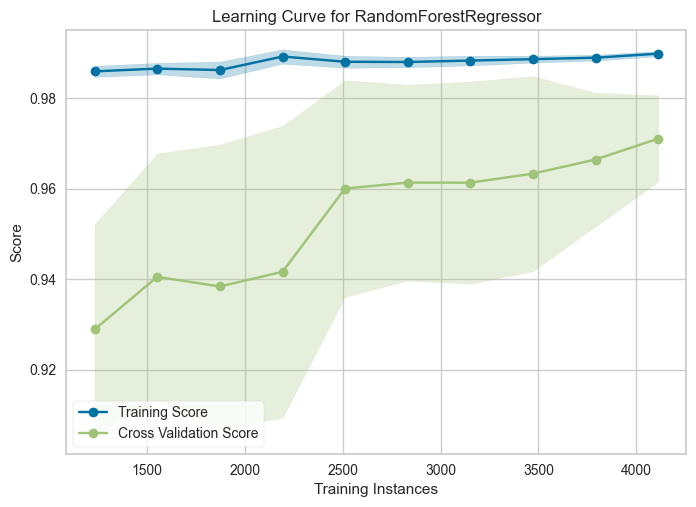

In [58]:
#Plot learning Curve
plot_model(rf_outdoor, plot = 'learning')

As shown in the learning curve, model training score doesn't increase greatly with with an increase in training instances between. In contrast, cross-validation model scores increase moderately from around 93% to 97%.

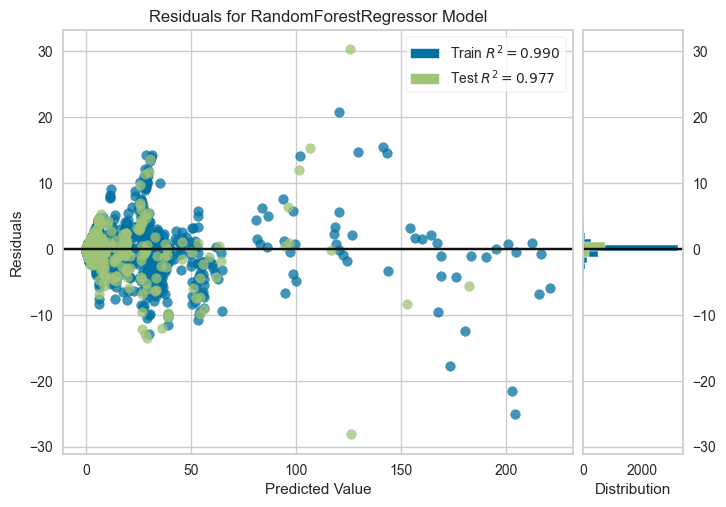

In [61]:
# Plot Residuals
plot_model(rf_outdoor, plot = 'residuals')

In [87]:
print('Mean Deaths= %.3f | Max Deaths= %.3f'%(round(np.mean(df_in['Deaths_PM2.5']),2),round(np.max(df_in['Deaths_PM2.5']),2)))

Mean Deaths= 5.360 | Max Deaths= 229.070


The residuals plot shows the distribution of residual (delta between actual vs predicted indoor air pollution deaths), which are largely within +/-5 deaths per 100,000, which is quite poor on the individual country level considering the {mean,max} of the metric. Despite this the R2 is around 97%. The highly right-skewed target values may be causing issues.

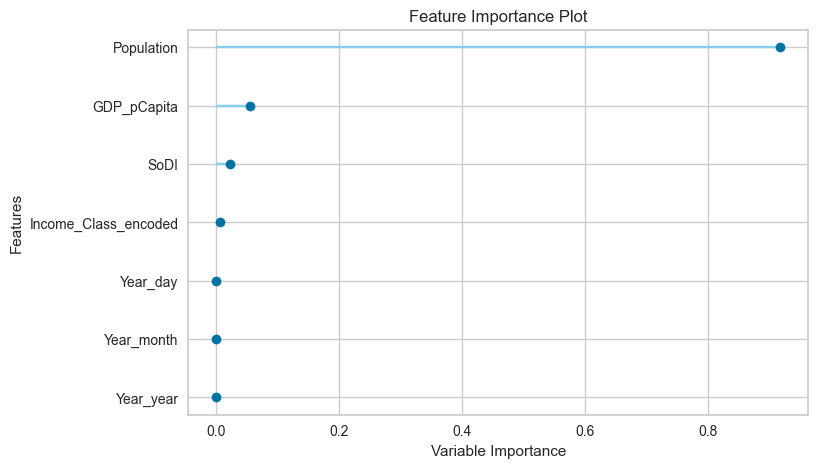

In [67]:
# Plot Feature Importance - Variable Importance (different from average importance shown in dashbaoard)
plot_model(rf_outdoor, plot = 'feature')

The Feature Importance plot shows that the Population drives the model at a variable importance of around 0.95, with GDP per capita coming in a distance second at around 0.1. The year does not seem to contribute much, which could be a problem when projecting the model forward into time.

#### 3.1.4 Predict

In [65]:
#Use random forest model to predict holdout testing dataset indoor pollution deaths per 100,000
predictions = predict_model(rf_outdoor)
predictions

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.8053,5.0340,2.2436,0.9767,0.2001,0.7372


,GDP_pCapita,Population,SoDI,Income_Class_encoded,Year,Deaths_PM2.5,prediction_label
1025,5386.467773,14587367.0,0.630,2.0,1970-01-01 00:00:00.000001996,0.182761,0.161715
935,21227.347656,29610218.0,0.809,3.0,1970-01-01 00:00:00.000001996,0.067681,0.145434
3024,117254.742188,607950.0,0.894,3.0,1970-01-01 00:00:00.000002018,2.326820,6.191070
3584,10171.480469,10289.0,0.573,3.0,1970-01-01 00:00:00.000002014,94.461243,94.875011
2131,477.762451,7081119.0,0.190,0.0,1970-01-01 00:00:00.000001994,0.266641,0.265382
...,...,...,...,...,...,...,...
524,2993.033691,230248.0,0.494,1.0,1970-01-01 00:00:00.000001998,9.620074,7.299584
5227,590.393494,4413477.0,0.556,0.0,1970-01-01 00:00:00.000001998,1.620225,1.279303
2883,7948.685547,5537620.0,0.660,2.0,1970-01-01 00:00:00.000002012,1.067985,1.064601
3941,1664.245728,3494496.0,0.467,1.0,1970-01-01 00:00:00.000002007,1.166933,0.832874


Even with the hold-out testing dataset, the tuned model has RMSE,MAE,R2 not drastically different from the test-train dataset used to build the model, so it shows that the model was not overfitted to the input data.

In [89]:
#Save Model
save_model(rf_outdoor,'OutdoorPM2.5 Deaths Random Forest 2023-03-29')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\kevin\AppData\Local\Temp\joblib),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['Year'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['GDP_pCapita', 'Population',
                                              'SoDI', 'Income_Class_encoded'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model',
                  RandomForestRegressor(max_depth=7, n_jobs=-1,
                                        random_state=123))]),
 'OutdoorPM2.5 Deaths Random Forest 2023-03-29.pkl')

### 3.3 Model Selection for Outdoor Pollution - OZone

Now we will test models for predictions on outdoor OZone pollution deaths.

**Without target transformation:** <br>
Predicting deaths due to OZone pollution appears to be more difficult. All MAE/MSE/RMSE/RMSLE values are all close to 0 because the amplitudes of the target is very small. If we scale the target as shown above, the model performance is even worse. Extra Trees Regressor appears to have an acceptable R2 of 0.7-0.8. <br>
**With target transformation**: <br>
Extra Trees Regressor R2 = 0.65, which is worse.

In [69]:
#Dependent variable - classify the level of indoor pollution death
y=df_in.loc[:,['Deaths_OZone']]

In [70]:
dataset = pd.concat([X,y],axis=1)

#### 3.3.1 Determine Top 3 Models

In [71]:
# Initialize the PyCaret setup
s = setup(data=dataset,target='Deaths_OZone',
          numeric_features=num_features,date_features=date_features,train_size=0.8,
          use_gpu=True,fold=10,n_jobs=-1,session_id=123) 

,Description,Value
0,Session id,123
1,Target,Deaths_OZone
2,Target type,Regression
3,Original data shape,"(5712, 6)"
4,Transformed data shape,"(5712, 8)"
5,Transformed train set shape,"(4569, 8)"
6,Transformed test set shape,"(1143, 8)"
7,Numeric features,4
8,Date features,1
9,Preprocess,True


In [72]:
# Multi-model training/test - Compare Mean Absolute Error
# Select the best 3 models - Create a blended model this time
best_3_ozone = compare_models(sort='MAE',budget_time=30,fold=10,exclude='lightgbm',n_select=3) 
# 30 mins budget time
# remove Light gradient boosting - causes error

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0305,0.0682,0.2051,0.8531,0.0685,0.7843,3.8210
dt,Decision Tree Regressor,0.0308,0.1158,0.2738,0.7371,0.0974,0.5801,2.3920
et,Extra Trees Regressor,0.0357,0.0805,0.2226,0.8393,0.0738,1.2412,3.0330
knn,K Neighbors Regressor,0.0462,0.0500,0.1942,0.8823,0.0921,1.9850,2.9620
gbr,Gradient Boosting Regressor,0.0598,0.0996,0.2551,0.7820,0.1001,2.5866,3.2160
ada,AdaBoost Regressor,0.0950,0.1196,0.2983,0.7475,0.1313,17.0098,2.6670
huber,Huber Regressor,0.1797,0.5137,0.6994,0.0305,0.2387,25.7144,2.4580
lar,Least Angle Regression,0.2084,0.4939,0.6870,0.0607,0.2530,30.6889,2.4930
ridge,Ridge Regression,0.2084,0.4939,0.6870,0.0608,0.2530,30.6878,2.9150
lr,Linear Regression,0.2084,0.4939,0.6870,0.0607,0.2530,30.6889,2.4520


Processing:   0%|          | 0/51 [00:00<?, ?it/s]

In [74]:
best_3_ozone

[RandomForestRegressor(n_jobs=-1, random_state=123),
 DecisionTreeRegressor(random_state=123),
 ExtraTreesRegressor(n_jobs=-1, random_state=123)]

In [75]:
# Check the model parameters in top 3
best_3_ozone[1].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 123,
 'splitter': 'best'}

#### 3.3.2 Blended Model

In [76]:
# Initialize 3 best models, Capping max_depth at 7
dt_ozone = create_model('dt',max_depth=7)
rf_ozone = create_model('rf',max_depth=7)
et_ozone = create_model('et',max_depth=7)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0353,0.0110,0.1049,0.9837,0.0732,1.5804
1,0.0505,0.0446,0.2111,0.8435,0.1181,1.6742
2,0.0269,0.0093,0.0967,0.9741,0.0654,1.5017
3,0.0415,0.0282,0.1680,0.9666,0.0872,1.1859
4,0.0603,0.0937,0.3060,0.8362,0.1398,1.8607
5,0.0295,0.0148,0.1217,0.9655,0.0708,1.4705
6,0.0488,0.0246,0.1569,0.9695,0.1069,1.8135
7,0.0487,0.0899,0.2999,0.5672,0.1305,1.6167
8,0.0692,0.4483,0.6695,0.4019,0.1471,1.0859


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0382,0.0120,0.1097,0.9822,0.0699,1.5989
1,0.0494,0.0259,0.1610,0.9090,0.0917,1.7343
2,0.0318,0.0082,0.0905,0.9773,0.0641,1.6632
3,0.0419,0.0185,0.1358,0.9782,0.0705,1.3048
4,0.0485,0.0329,0.1813,0.9425,0.0796,1.9051
5,0.0442,0.0553,0.2352,0.8712,0.0693,1.6845
6,0.0461,0.0157,0.1255,0.9805,0.0907,1.6854
7,0.0332,0.0117,0.1082,0.9436,0.0662,1.4661
8,0.0590,0.2573,0.5072,0.6567,0.0917,1.0293


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1447,0.2753,0.5247,0.5929,0.1617,13.1139
1,0.1197,0.0903,0.3005,0.6828,0.1550,12.3724
2,0.1307,0.1455,0.3814,0.5976,0.1686,14.2388
3,0.1583,0.3035,0.5509,0.6410,0.1735,11.7671
4,0.1365,0.1574,0.3967,0.7247,0.1563,14.4973
5,0.1207,0.2396,0.4895,0.4421,0.1534,12.5807
6,0.1560,0.3620,0.6017,0.5513,0.1737,11.6353
7,0.1075,0.0948,0.3078,0.5440,0.1412,14.4467
8,0.1436,0.4006,0.6330,0.4654,0.1639,11.9561


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [77]:
# Develop a blended model with voting regressor
blended_ozone = blend_models(estimator_list=[dt_ozone,rf_outdoor,et_ozone],optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0684,0.0441,0.2101,0.9347,0.0849,5.3115
1,0.0681,0.0377,0.1942,0.8676,0.1046,5.1505
2,0.0582,0.0222,0.1490,0.9386,0.0815,5.6781
3,0.0752,0.0568,0.2383,0.9328,0.0937,4.6550
4,0.0772,0.0640,0.2529,0.8881,0.1008,5.9912
5,0.0602,0.0700,0.2646,0.8369,0.0813,5.1246
6,0.0778,0.0496,0.2226,0.9386,0.1023,4.9438
7,0.0592,0.0380,0.1949,0.8171,0.0974,5.7316
8,0.0847,0.3421,0.5849,0.5436,0.1122,4.5609


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In this case the random forest individual models has a better MAE and R2 compared to the blended model.

#### 3.3.3 Stacked Model

A meta model, linear regression by default, is trained over the 3 selected regressors

In [90]:
# Develop a blended model with voting regressor
stacked_ozone = stack_models(estimator_list=[dt_ozone,rf_outdoor,et_ozone],optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0384,0.0103,0.1016,0.9847,0.0686,1.9161
1,0.0520,0.0306,0.1750,0.8924,0.0968,2.7537
2,0.0314,0.0078,0.0883,0.9785,0.0610,2.1320
3,0.0431,0.0189,0.1375,0.9776,0.0714,2.4320
4,0.0499,0.0316,0.1778,0.9447,0.0799,3.0693
5,0.0469,0.0600,0.2449,0.8603,0.0712,2.2730
6,0.0512,0.0191,0.1383,0.9763,0.0922,2.6935
7,0.0376,0.0191,0.1382,0.9080,0.0785,2.6018
8,0.0642,0.2677,0.5174,0.6428,0.0939,3.2557


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

This model has roughly equivalent results to the random forest model.

#### 3.3.3 Evaluate Model

Assume that random forest model is the most appropriate

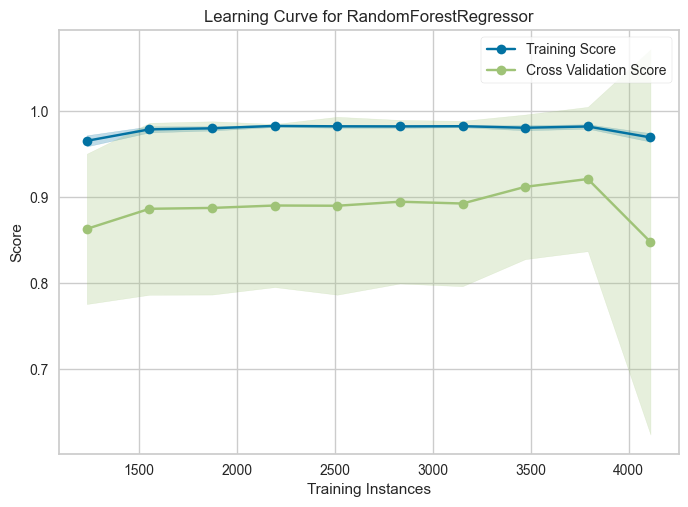

In [78]:
#Plot learning Curve
plot_model(rf_ozone, plot = 'learning')

Cross-validation model scores hardly increase from 85% to 90% with an increase in training instances.

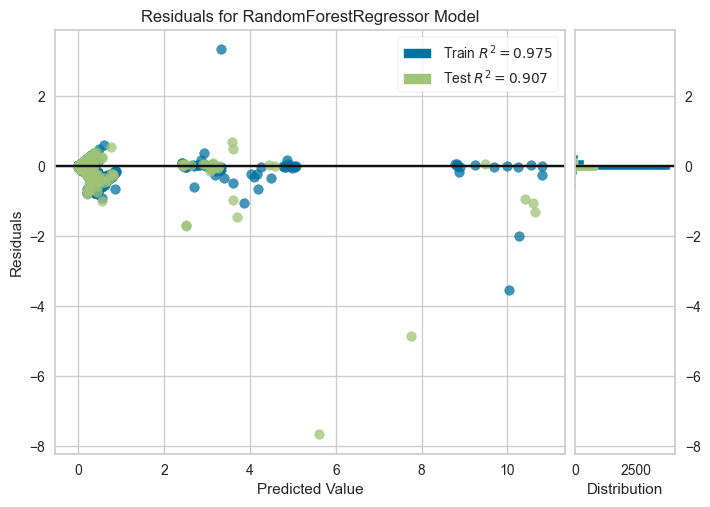

In [79]:
# Plot Residuals
plot_model(rf_ozone, plot = 'residuals')

The residuals plot shows the distribution of residual (delta between actual vs predicted indoor air pollution deaths), which are largely within +/-10 deaths per 100,000, which is reasonable on the individual country level considering the {mean,max} of the metric = {20,2830}, considering the R2 is actually around 97%

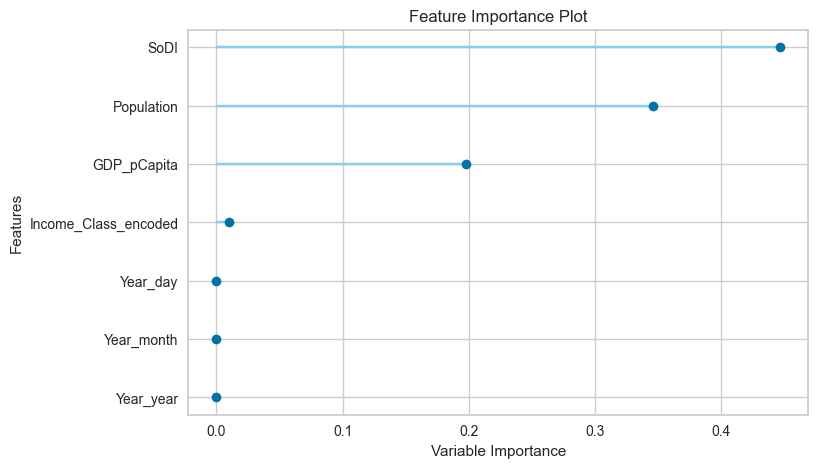

In [80]:
# Plot Feature Importance - Variable Importance (different from average importance shown in dashbaoard)
plot_model(rf_ozone, plot = 'feature')

The Feature Importance plot shows that the SoDI drives the model at a variable importance of around 0.45, with Population in second at around 0.35, and third with GDP per capita at around 0.2.

#### 3.3.4 Predict

In [91]:
#Use random forest model to predict holdout testing dataset indoor pollution deaths per 100,000
predictions = predict_model(rf_ozone)
predictions

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0571,0.0935,0.3058,0.9068,0.0776,1.5183


,GDP_pCapita,Population,SoDI,Income_Class_encoded,Year,Deaths_OZone,prediction_label
1025,5386.467773,14587367.0,0.630,2.0,1970-01-01 00:00:00.000001996,0.004042,0.005366
935,21227.347656,29610218.0,0.809,3.0,1970-01-01 00:00:00.000001996,0.004505,0.004721
3024,117254.742188,607950.0,0.894,3.0,1970-01-01 00:00:00.000002018,0.324673,0.461738
3584,10171.480469,10289.0,0.573,3.0,1970-01-01 00:00:00.000002014,0.000000,0.000000
2131,477.762451,7081119.0,0.190,0.0,1970-01-01 00:00:00.000001994,0.005983,0.009433
...,...,...,...,...,...,...,...
524,2993.033691,230248.0,0.494,1.0,1970-01-01 00:00:00.000001998,0.188629,0.162806
5227,590.393494,4413477.0,0.556,0.0,1970-01-01 00:00:00.000001998,0.024129,0.054696
2883,7948.685547,5537620.0,0.660,2.0,1970-01-01 00:00:00.000002012,0.029349,0.022826
3941,1664.245728,3494496.0,0.467,1.0,1970-01-01 00:00:00.000002007,0.022929,0.029863


Even with the hold-out testing dataset, the tuned model has RMSE,MAE,R2 not drastically different from the test-train dataset used to build the model, so it shows that the model was not overfitted to the input data.

In [92]:
#Save Model
save_model(rf_ozone,'Ozone Deaths Random Forest 2023-03-29')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\kevin\AppData\Local\Temp\joblib),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['Year'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['GDP_pCapita', 'Population',
                                              'SoDI', 'Income_Class_encoded'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model',
                  RandomForestRegressor(max_depth=7, n_jobs=-1,
                                        random_state=123))]),
 'Ozone Deaths Random Forest 2023-03-29.pkl')